# This Notebook computes the Gabor texture features from the ROI images.

In [15]:
# Import section
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.filters import gabor_kernel
from scipy import signal as sg
import shutil

In [16]:
cwd=os.getcwd()

In [17]:
# Create folders if don't exist.
try:
    os.makedirs(cwd+'/features')
    os.makedirs(cwd+'/images')
except:
    pass

#Logic to copy ROI's calculated to one folder named 'image' for feature extraction
if len(os.listdir(cwd+'/images'))==0:
    for i in os.listdir(cwd+'/ROIs'):
        if os.path.isdir(cwd+'/ROIs/'+i):
            if len(os.listdir(cwd+'/ROIs/'+i+'/ROIs/'))==0:
                print("Folder of ROI empty")
            else:
                for j in os.listdir(cwd+'/ROIs/'+i+'/ROIs/'):
                    shutil.copy(cwd+'/ROIs/'+i+'/ROIs/'+j,cwd+'/images')
else:
    pass
#     print("Files exist in image folder")

# Location of images.
image_dir = cwd + '/images/'

# Location of where to write features.
feature_dir = cwd + '/features/'

# The .csv file containing the image names and classes.
image_file = cwd + '/image_names_classes.csv'

In [18]:
# Number of images.
n_images = 218

# Read image names and classes .csv file.
image_names_classes = pd.read_csv(image_file, header=None )


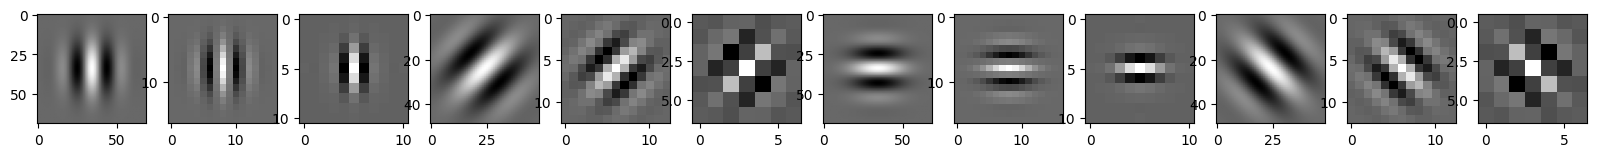

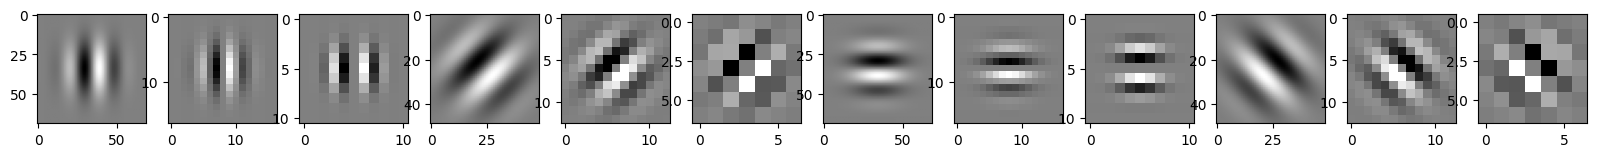

In [19]:
# Create Gabor filter bank kernels.
kernels = []

# EXPERIMENT WITH THE NUMBER OF ORIENTATIONS AND SCALES.
# This code will create a feature file with the name Gabor_Y_X_.txt
# where X is the number of scales and Y number of orientations.

nscales = 3
norientations = 4

min_frequency = 0.05
max_frequency = 0.4

for orientation in range(norientations):
    theta = (orientation / norientations) * np.pi
    for scale in range(nscales):
        frequency = min_frequency + scale*((max_frequency - min_frequency)/(nscales-1))
        kernel = gabor_kernel(frequency, theta=theta)
        kernels.append(kernel)
        #print('orientation='+str(orientation)+': theta='+str(theta)) 
        #print('scale='+str(scale)+': frequency='+str(frequency)) 

# Visualize the filters as images. Note that the filters have different sizes--see the axes in the plots below.
# The filters are complex so first visualize the real parts and then the imaginary parts.
fig, axs = plt.subplots(1, len(kernels), figsize=(20,20))
for k, kernel in enumerate(kernels):
    axs[k].imshow(np.real(kernel),cmap='gray')
    
fig, axs = plt.subplots(1, len(kernels), figsize=(20,20))
for k, kernel in enumerate(kernels):
    axs[k].imshow(np.imag(kernel),cmap='gray')


In [20]:
# Mean and standard deviation will be computed for each filter output.
fdim = 2 * len(kernels)

features = np.zeros((n_images, fdim))

In [21]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels) * 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = sg.convolve(image, kernel)
        feats[2*k] = np.abs(filtered).mean()
        feats[2*k+1] = np.abs(filtered).std()
    return feats

In [22]:
# Extract features for each image.
for i in range(n_images):
    
    # Read the image.
    filename = image_dir + image_names_classes[0][i]    
    im = plt.imread(filename)
    
    # It turns out that the spectrogram images saved using plt.imsave have four channels
    # RGBA. The RGB channels are each equal to the grayscale value so we can use any of them.
    
    features[i, :] = compute_feats(im[:,:,0], kernels)
    
# Save the features as a .csv file.
gabor_filename='Gabor'+'_'+str(nscales)+'_'+str(norientations)+'.txt'
feature_filename = feature_dir +  gabor_filename

np.savetxt(feature_filename, features, delimiter=',')